In [1]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import os
import seaborn as sns

In [2]:
def calc_msd_all(data, min_locs, pixel_scale, tau, max_lag):
    """
    Generate histogram of D_app as determined by fitting mean squared displacements
    """
    # data = pd.read_csv(filename, index_col=0)
    track_ids = np.unique(data['n'])
    
    D_app = []
    track_ids_D = []
    id2nlocs = {}
    
    for tid in track_ids:

        track_filt = data['n'] == tid
        n_locs = track_filt.sum()

        if n_locs >= min_locs:
            frames = data['frame'][track_filt].values
            rows = data['y'][track_filt].values
            cols = data['x'][track_filt].values
            id2nlocs[tid] = n_locs

            for i in range(0, n_locs-min_locs+1):
                frames_seg = frames[i:i+min_locs]
                rows_seg = rows[i:i+min_locs]
                cols_seg = cols[i:i+min_locs]

                D_app.append(calc_msd(frames_seg, rows_seg, cols_seg, pixel_scale, tau, max_lag))
                track_ids_D.append(tid)

    D_app = np.array(D_app)
    track_ids_D = np.array(track_ids_D)
    
    return D_app, track_ids_D
    


def calc_msd(frames, rows, cols, pixel_size, tau, max_lag):
    """
    Calculate D_app by fitting line to mean squared displacements 
    """
    n_locs = len(frames)
    
    msd_num = np.zeros(max_lag+1)
    msd_den = np.zeros(max_lag+1)
    
    for offset in range(1,n_locs):
        dFrame = frames[offset:] - frames[:-offset]
        sd = ((rows[offset:] - rows[:-offset])**2 + (cols[offset:] - cols[:-offset])**2) * pixel_size**2 # squared displacement, um^2
        msd_num += np.histogram(dFrame,
                                bins=np.arange(1, max_lag+3),
                                weights=sd)[0] # numerator of mean squared displacement
        msd_den += np.histogram(dFrame,
                                bins=np.arange(1, max_lag+3))[0] # denominator of mean squared displacement
        
    msd_num = msd_num[:-1]
    msd_den = msd_den[:-1]
        
    non_empty_lags = msd_den > 0
    msd = (msd_num[non_empty_lags] / msd_den[non_empty_lags]) # * (pixel_size)**2 # um^2

    lags_frame = np.arange(1, max_lag+1)[non_empty_lags] # frames
    lags_time = lags_frame * tau # seconds
    
    msd_den = msd_den[non_empty_lags]
    sum_w = msd_den.sum()
    sum_wxy = (msd_den * lags_time * msd).sum()
    sum_wx = (msd_den * lags_time).sum()
    sum_wy = (msd_den * msd).sum()
    sum_wx2 = (msd_den * lags_time**2).sum()
    
    D_app = 0.25 * (sum_w*sum_wxy - sum_wx*sum_wy) / (sum_w*sum_wx2 - sum_wx**2)
                                                
    return D_app

# Part 1: Calculating D_app for all possible segments

In [5]:
folder = r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Small Batch Water'
fname = r'small_batch_water_movie_notes.xlsx'
movie_notes = pd.read_excel(join(folder, fname), sheet_name=None)

movie_notes_rep = movie_notes['BR3']
movie_list = movie_notes_rep['Movie'][~(movie_notes_rep['Exclude']=='x')]

folder_rep = r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Small Batch Water\BR3\2023-06-29__rois_g-r_radsym_cons'

summary = pd.DataFrame(columns=['file', 
                                'steps', 
                                'tracks', 
                                'steps_filt', 
                                'tracks_filt', 
                                '% steps', 
                                '% tracks',
                                'max_len', 
                                'mean_len', 
                                'std_len', 
                                'med_len'],
                      index=range(len(movie_list)))

D_app_dict = {}
track_ids_dict = {}

min_locs = 20
pixel_scale = 1
tau = 0.25
max_lag = 19

for i, movie in enumerate(movie_list):
    file = join(folder_rep, movie+'.locs')
    data = pd.read_csv(file, index_col=0)


    data_grouped  = data.groupby('n')
    data_filt = data_grouped.filter(lambda x: (x['n'].count() >= min_locs))
    
    total_tracks = len(np.unique(data['n']))
    total_steps = len(data)
    total_tracks_filt = len(np.unique(data_filt['n']))
    total_steps_filt = len(data_filt)
    
    summary.loc[i, 'file'] = Path(file).stem
    summary.loc[i, 'steps'] = total_steps
    summary.loc[i, 'steps_filt'] = total_steps_filt
    summary.loc[i, 'tracks'] = total_tracks
    summary.loc[i, 'tracks_filt'] = total_tracks_filt
    
    data_filt_grouped = data_filt.groupby('n')
    summary.loc[i, 'max_len'] = data_filt_grouped['n'].count().max()
    summary.loc[i, 'mean_len'] = data_filt_grouped['n'].count().mean()
    summary.loc[i, 'std_len'] = data_filt_grouped['n'].count().std()
    summary.loc[i, 'med_len'] = np.median(data_filt_grouped['n'].count())
    
    D_app, track_ids_D = calc_msd_all(data_filt, min_locs, pixel_scale, tau, max_lag)
    
    D_app_dict[file] = D_app
    track_ids_dict[file] = track_ids_D
    
D_app_data = {'D_app': D_app_dict,
             'ids': track_ids_dict}
    
summary['% steps'] = summary['steps_filt']/summary['steps'] * 100
summary['% tracks'] = summary['tracks_filt']/summary['tracks'] * 100

summary.to_csv(join(folder_rep, 'tracks summary.csv'))
np.save(join(folder_rep, 'D_app_data.npy'), D_app_data, allow_pickle=True)

# Part 2: Sampling segments, generating histograms, calculating mobile fractions

In [6]:
# strains = ['DB841']
# strains = ['DK1906', 'DK2118', 'DK4347', 'DK479', 'DK4892', 'DK5081', 'DK5082', 'DK5083', 'DK5084', 'DK5268', 'DK8583', 'DK9057']
# strains = ['DK479']
strains = ['CH', 'LB', 'PBS', 'WT']
# , ' br2', ' br2(replace)'

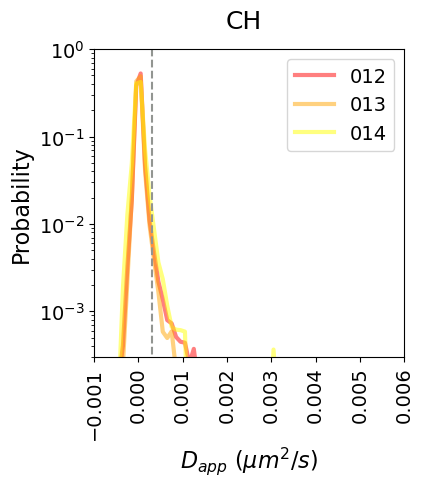

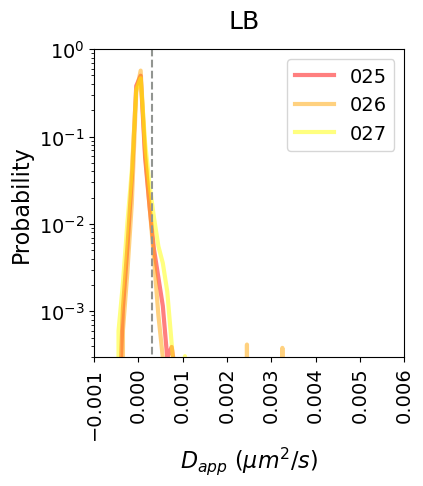

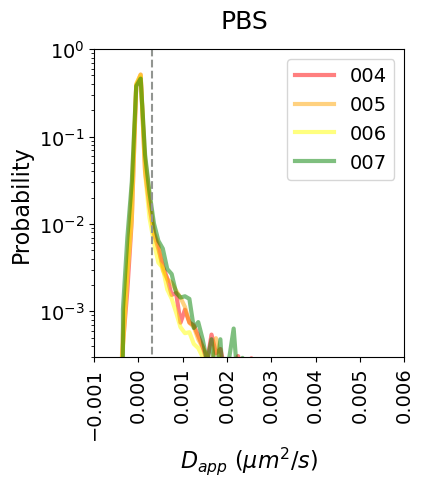

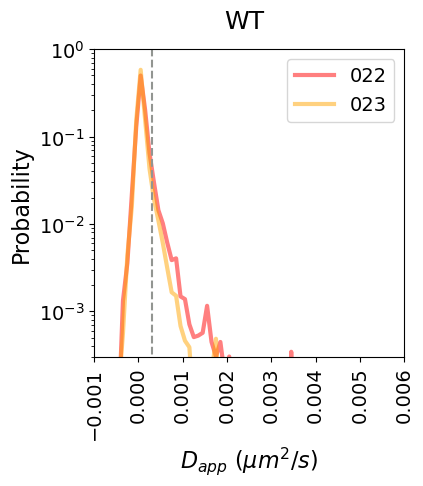

In [9]:
folder = r'T:\MIGRATED\Lab_Members\Daniel_Foust\Data\Basal Bodies\mutants\Condition Changes 2\BR3\2023-06-29__rois_g-r_radsym_cons'
fname = r'D_app_data.npy'

figfolder = r'D_app histograms'

if not os.path.exists(join(folder, figfolder)):
    os.makedirs(join(folder, figfolder))

D_app_data = np.load(join(folder, fname), allow_pickle=True).item()
allkeys = D_app_data['D_app'].keys()

min_locs = 20
n_bootlegs = 50 # I meant bootstraps, but dummy!
bins = np.arange(-0.004, 0.025, 0.0001)
mob_th = 0.0003 # mobility threshold

D_app_all = {}

for strain in strains:
    strainkeys = [key for key in allkeys if strain in key]
    D_app_all[strain] = {sk: {} for sk in strainkeys}
    for sk in strainkeys:
        D_app = D_app_data['D_app'][sk]
        ids = D_app_data['ids'][sk]
        D_app_bl = {nb: [] for nb in range(n_bootlegs)}
        ids_long = []
        n_locs_total = 0
        for i in np.unique(ids):
            n_locs = min_locs + (ids==i).sum() - 1
            n_locs_total += n_locs
            ids_long += [i]*n_locs
            
        n_samp = n_locs_total // min_locs
        for nb in range(n_bootlegs):
            randints = (np.random.uniform(size=n_samp) * len(ids_long)).astype('int')
            ids_samp = np.array(ids_long)[randints]
            D_app_bl[nb] = np.concatenate([np.random.choice(D_app[ids==ismp], size=(ids_samp==ismp).sum()) for ismp in np.unique(ids_samp)])
            D_app_all[strain][sk][nb] = D_app_bl[nb]

results = pd.DataFrame(columns=['movie', 'strain', 'n',
                                'f_mobile mean', 'f_mobile stdev', 'f_mobile median'],
                      index=range(len(allkeys))); j = 0
            
# strain = 'DK1906'
for strain in strains:
    # print(strain)
    movies = D_app_all[strain].keys()

    hists = {}

    for movie in movies:
        bootlegs = D_app_all[strain][movie].keys()
        hists[movie] = {}
        for bootleg in bootlegs:
            d_app = D_app_all[strain][movie][bootleg]
            hists[movie][bootleg] = np.histogram(d_app, bins=bins)[0]

    fig, ax = plt.subplots(1,1,figsize=(4,4))
    fig.suptitle(strain, fontsize=18)

    colors = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue'}

    for i, m in enumerate(hists): # m: movie
        f_mob_bl = np.zeros(len(hists[m]))
        hnorm = np.zeros([len(hists[m]), len(hists[m][0])])
        for bl in hists[m]:
            hnorm[bl,:] = hists[m][bl] / hists[m][bl].sum()
            f_mob_bl[bl] = hnorm[bl][bins[:-1]>=mob_th].sum()
            # print(i, hists[m][bl].sum(), f_mob_bl.mean(), f_mob_bl.std(), np.median(f_mob_bl))
            # print(hnorm[bins[:-1]>=0.0003].sum())
        hnorm_mean = hnorm.mean(axis=0)
        ax.plot((bins[1:]+bins[:-1])/2, hnorm_mean, alpha=0.5, color=colors[i], label=Path(m).stem[-3:], lw=3)     
        
        results.loc[j, 'movie'] = m
        results.loc[j, 'strain'] = strain
        results.loc[j, 'n'] = hists[m][bl].sum()
        results.loc[j, 'f_mobile mean']  = f_mob_bl.mean()
        results.loc[j, 'f_mobile stdev'] = f_mob_bl.std()
        results.loc[j, 'f_mobile median'] = np.median(f_mob_bl)
        # print(results[j])
        j += 1
        
    ax.plot([mob_th, mob_th], [-1,1], '--', color='xkcd:gray')
    ax.set_xlim([-0.001, 0.006])
    ax.set_ylim([3e-4, 1])
    ax.set_yscale('log')
    plt.legend(loc='upper right', fontsize=14)
    plt.xlabel(r'$D_{app}\ (\mu m^2/s)$', fontsize=16)
    plt.ylabel('Probability', fontsize=16)

    plt.xticks(fontsize=14, rotation='vertical')
    plt.yticks(fontsize=14);
    
    plt.savefig(join(folder, figfolder, strain+'.png'),
               dpi=450,
               bbox_inches='tight',
               transparent=True)
    
results.to_csv(join(folder, 'mobility results.csv'))

DK1906
0.008199776369735371
0.010063361908311592
0.0126723816623183
0.008572493477450614
0.0126723816623183
0.008572493477450614
0.010436079016026835
0.009317927692881103
0.008945210585165859
0.009317927692881103
0.011854360711261641
0.00846740050804403
0.012701100762066046
0.006773920406435224
0.011854360711261643
0.005080440304826418
0.00846740050804403
0.010160880609652836
0.009314140558848433
0.011007620660457238
0.014285714285714287
0.014285714285714287
0.03035714285714286
0.026785714285714288
0.030357142857142857
0.014285714285714285
0.019642857142857142
0.02142857142857143
0.025
0.02142857142857143
DK5082
0.017644006227296314
0.01608718214841723
0.017125064867669952
0.014011416709911781
0.015568240788790867
0.01660612350804359
0.017644006227296314
0.015049299429164503
0.011416709911779968
0.014530358069538141
0.035161744022503515
0.02625410220346929
0.03375527426160337
0.02625410220346929
0.03375527426160337
0.02719174871073605
0.030004688232536336
0.030942334739803096
0.0300046

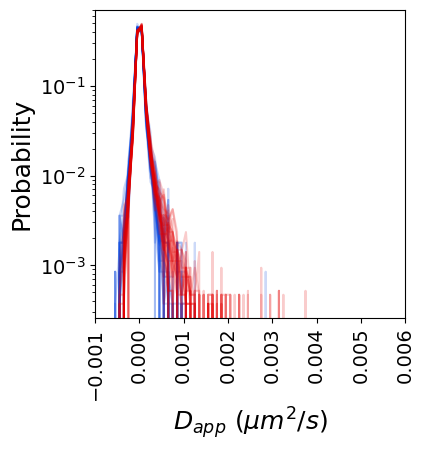

In [161]:
folder = r'E:\Data\Kearns\TIRF from Caroline in Kearns Lab Caroline Dunn\Strain Comparison\Strains Bio Rep 2\2023-06-21_g-r_radsym_cons'
fname = r'D_app_data.npy'

D_app_data = np.load(join(folder, fname), allow_pickle=True).item()

min_locs = 20
n_bootlegs = 10

D_app_all = {}

for strain in strains:
    allkeys = D_app_data['D_app'].keys()
    strainkeys = [key for key in allkeys if strain in key]
    D_app_all[strain] = {sk: {} for sk in strainkeys}
    for sk in strainkeys:
        D_app = D_app_data['D_app'][sk]
        ids = D_app_data['ids'][sk]
        D_app_bl = {nb: [] for nb in range(n_bootlegs)}
        for i in np.unique(ids):
            n_locs = min_locs + (ids==i).sum() - 1
            n_samp = n_locs // min_locs
            D_app_i = D_app[ids==i]
            for nb in range(n_bootlegs):
                D_app_samp_i = np.random.choice(D_app_i, size=n_samp)
                D_app_bl[nb].append(D_app_samp_i)
        for nb in range(n_bootlegs):
            D_app_all[strain][sk][nb] = np.concatenate(D_app_bl[nb])
            
strain = 'DK1906'
print(strain)
bins = np.arange(-0.004, 0.025, 0.0001)

movies = D_app_all[strain].keys()

hists = {}

for movie in movies:
    bootlegs = D_app_all[strain][movie].keys()
    hists[movie] = {}
    for bootleg in bootlegs:
        d_app = D_app_all[strain][movie][bootleg]
        hists[movie][bootleg] = np.histogram(d_app, bins=bins)[0]

fig, ax = plt.subplots(1,1,figsize=(4,4))

colors = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue'}

for i, m in enumerate(hists):
    for bl in hists[m]:
        hnorm = hists[m][bl] / hists[m][bl].sum()
        print(hnorm[bins[:-1]>=0.00025].sum())
        ax.plot((bins[1:]+bins[:-1])/2, hnorm, color='xkcd:blue', alpha=0.2)
    
ax.set_xlim([-0.001, 0.006])
ax.set_yscale('log')

strain = 'DK5082'
print(strain)
bins = np.arange(-0.004, 0.025, 0.0001)

movies = D_app_all[strain].keys()

hists = {}

for movie in movies:
    bootlegs = D_app_all[strain][movie].keys()
    hists[movie] = {}
    for bootleg in bootlegs:
        d_app = D_app_all[strain][movie][bootleg]
        hists[movie][bootleg] = np.histogram(d_app, bins=bins)[0]

# fig, ax = plt.subplots(1,1,figsize=(4,4))

colors = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue'}

for i, m in enumerate(hists):
    for bl in hists[m]:
        hnorm = hists[m][bl] / hists[m][bl].sum()
        print(hnorm[bins[:-1]>=0.00025].sum())
        ax.plot((bins[1:]+bins[:-1])/2, hnorm, color='xkcd:red', alpha=0.2)
    
ax.set_xlim([-0.001, 0.006])
ax.set_yscale('log')

plt.xlabel(r'$D_{app}\ (\mu m^2/s)$', fontsize=18)
plt.ylabel('Probability', fontsize=18)

plt.xticks(fontsize=14, rotation='vertical')
plt.yticks(fontsize=14);

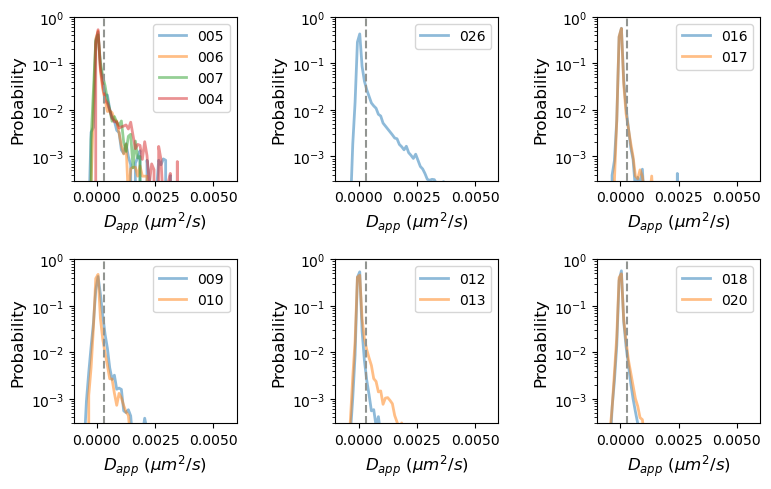

In [20]:
folder = r'E:\Data\Kearns\TIRF from Caroline in Kearns Lab Caroline Dunn\Inducible flache timepoints\Inducible Bio Rep 3\2023-07-05_rois_g-r_radsym_cons_var-c'
fname = r'D_app_data.npy'

colors = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue'}

figfolder = r'D_app histograms'

if not os.path.exists(join(folder, figfolder)):
    os.makedirs(join(folder, figfolder))

D_app_data = np.load(join(folder, fname), allow_pickle=True).item()
allkeys = D_app_data['D_app'].keys()

results = pd.DataFrame(columns=['movie', 't_tot', 't_inc', 'n',
                                'f_mobile mean', 'f_mobile stdev', 'f_mobile median'],
                      index=range(len(allkeys))); j = 0

min_locs = 20
n_bootlegs = 50 # I meant bootstraps, but dummy!
bins = np.arange(-0.004, 0.025, 0.0001)
mob_th = 0.0003 # mobility threshold

D_app_all = {key: {} for key in allkeys}

for key in list(allkeys):
    D_app = D_app_data['D_app'][key]
    ids = D_app_data['ids'][key]
    D_app_bl = {nb: [] for nb in range(n_bootlegs)}
    ids_long = []
    n_locs_total = 0
    for i in np.unique(ids):
        n_locs = min_locs + (ids==i).sum() - 1
        n_locs_total += n_locs
        ids_long += [i]*n_locs
        
        n_samp = n_locs_total // min_locs
        for nb in range(n_bootlegs):
            randints = (np.random.uniform(size=n_samp) * len(ids_long)).astype('int')
            ids_samp = np.array(ids_long)[randints]
            D_app_bl[nb] = np.concatenate([np.random.choice(D_app[ids==ismp], size=(ids_samp==ismp).sum()) for ismp in np.unique(ids_samp)])
            D_app_all[key][nb] = D_app_bl[nb]
            
time2ax = {3: (0,0), 5: (0,1), 10: (0,2),
           15: (1,0), 30: (1,1), 45: (1,2)}

fig, ax = plt.subplots(2, 3, figsize=(8,5))
            
movies = D_app_all.keys()

for movie in list(movies):
    
    t_inc = int(''.join(filter(str.isdigit, movie.split('mininc')[0].split('_')[-1])))
    t_tot = int(''.join(filter(str.isdigit, movie.split('mintot')[0].split('_')[-1])))
    ax_t = time2ax[t_inc]
    
    bootlegs = D_app_all[movie].keys()
    hists = {}
    for bootleg in bootlegs:
        d_app = D_app_all[movie][bootleg]
        hists[bootleg] = np.histogram(d_app, bins=bins)[0]
    
    f_mob_bl = np.zeros(len(hists))
    hnorm = np.zeros([len(hists), len(hists[0])])
    for bl in hists: # m: movie
        hnorm[bl,:] = hists[bl] / hists[bl].sum()
        f_mob_bl[bl] = hnorm[bl][bins[:-1]>=mob_th].sum()
        # print(i, hists[m][bl].sum(), f_mob_bl.mean(), f_mob_bl.std(), np.median(f_mob_bl))
        # print(hnorm[bins[:-1]>=0.0003].sum())
    hnorm_mean = hnorm.mean(axis=0)
    ax[ax_t].plot((bins[1:]+bins[:-1])/2, hnorm_mean, alpha=0.5, label=Path(movie).stem[-3:], lw=2)
    
    results.loc[j, 'movie'] = movie
    results.loc[j, 't_tot'] = t_tot
    results.loc[j, 't_inc'] = t_inc
    results.loc[j, 'n'] = hists[0].sum()
    results.loc[j, 'f_mobile mean']  = f_mob_bl.mean()
    results.loc[j, 'f_mobile stdev'] = f_mob_bl.std()
    results.loc[j, 'f_mobile median'] = np.median(f_mob_bl)
    j += 1
    
mob_th = 0.0003
for a in ax.ravel():
    a.plot([mob_th, mob_th], [-1,1], '--', color='xkcd:gray')
    a.set_xlim([-0.001, 0.006])
    a.set_ylim([3e-4, 1])
    a.set_yscale('log')
    a.legend(loc='upper right', fontsize=10)
    a.set_xlabel(r'$D_{app}\ (\mu m^2/s)$', fontsize=12)
    a.set_ylabel('Probability', fontsize=12)
    
plt.tight_layout()

plt.savefig(join(folder, figfolder, 'Dapp histograms by induction time.png'),
           dpi=450,
           bbox_inches='tight',
           transparent=True)

results.to_csv(join(folder, 'mobility results.csv'))

In [16]:
bootlegs

dict_keys([])

In [13]:
help(a.set_xticks)

Help on method set_xticks in module matplotlib.axes._base:

set_xticks(ticks, labels=None, *, minor=False, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Set the xaxis' tick locations and optionally labels.
    
    If necessary, the view limits of the Axis are expanded so that all
    given ticks are visible.
    
    Parameters
    ----------
    ticks : list of floats
        List of tick locations.
    labels : list of str, optional
        List of tick labels. If not set, the labels show the data value.
    minor : bool, default: False
        If ``False``, set the major ticks; if ``True``, the minor ticks.
    **kwargs
        `.Text` properties for the labels. These take effect only if you
        pass *labels*. In other cases, please use `~.Axes.tick_params`.
    
    Notes
    -----
    The mandatory expansion of the view limits is an intentional design
    choice to prevent the surprise of a non-visible tick. If you need
    other limits, you should se

In [35]:
f = list(allkeys)[10]

In [37]:
g = f.split('mininc')[0].split('_')[-1]

In [38]:
int(''.join(filter(str.isdigit, g)))

30

In [29]:
[s for s in g.split() if s.isdigit()]

[]

In [30]:
g.split()

['5thr']

In [14]:
results

,movie,strain,n,f_mobile mean,f_mobile stdev,f_mobile median
0,E:\Data\Kearns\TIRF from Caroline in Kearns La...,DK1906,3233,0.003594,0.000952,0.003712
1,E:\Data\Kearns\TIRF from Caroline in Kearns La...,DK1906,1475,0.002739,0.001356,0.002712
2,E:\Data\Kearns\TIRF from Caroline in Kearns La...,DK1906,946,0.006617,0.002664,0.006342
3,E:\Data\Kearns\TIRF from Caroline in Kearns La...,DK2118,3766,0.013643,0.001648,0.013542
4,E:\Data\Kearns\TIRF from Caroline in Kearns La...,DK2118,2463,0.013471,0.00235,0.012992
5,E:\Data\Kearns\TIRF from Caroline in Kearns La...,DK2118,3226,0.018903,0.001896,0.018754
6,E:\Data\Kearns\TIRF from Caroline in Kearns La...,DK2118,3434,0.018229,0.002236,0.018346
7,E:\Data\Kearns\TIRF from Caroline in Kearns La...,DK4347,906,0.001589,0.001212,0.001104
8,E:\Data\Kearns\TIRF from Caroline in Kearns La...,DK4347,2187,0.002533,0.000977,0.002286
9,E:\Data\Kearns\TIRF from Caroline in Kearns La...,DK4347,645,0.013457,0.00439,0.013953


DK1906
0.010392609699769052
0.009237875288683603
0.010007698229407237
0.010007698229407237
0.009237875288683604
0.00962278675904542
0.007698229407236336
0.010777521170130871
0.008083140877598153
0.0073133179368745195
0.007282260413632392
0.009030002912904164
0.007282260413632391
0.009903874162540051
0.00815613166326828
0.005825808330905913
0.008156131663268278
0.007864841246722983
0.00873871249635887
0.007864841246722983
0.009812667261373772
0.00951531370799881
0.00951531370799881
0.007433838834374071
0.011894142134998512
0.011002081474873623
0.00951531370799881
0.010704727921498661
0.009515313707998812
0.010704727921498661
DK5082
0.10109503324208056
0.09855299178725069
0.09522878373093469
0.09542432538130621
0.09835745013687916
0.0993351583887368
0.09972624168947986
0.09640203363316387
0.1020727414939382
0.09620649198279234
0.07484923731819794
0.07413976587442356
0.07254345512593117
0.0775097552323519
0.07272082298687478
0.07413976587442356
0.07343029443064916
0.07626818020574672
0.08

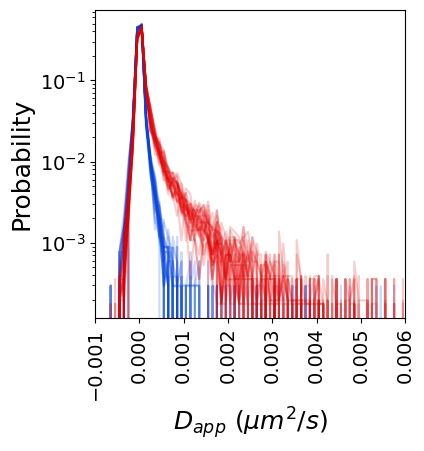

In [162]:
folder = r'E:\Data\Kearns\TIRF from Caroline in Kearns Lab Caroline Dunn\Strain Comparison\Strains Bio Rep 3\2023-06-21_g-r_radsym_cons'
fname = r'D_app_data.npy'

D_app_data = np.load(join(folder, fname), allow_pickle=True).item()

min_locs = 20
n_bootlegs = 10

D_app_all = {}

for strain in strains:
    allkeys = D_app_data['D_app'].keys()
    strainkeys = [key for key in allkeys if strain in key]
    D_app_all[strain] = {sk: {} for sk in strainkeys}
    for sk in strainkeys:
        D_app = D_app_data['D_app'][sk]
        ids = D_app_data['ids'][sk]
        D_app_bl = {nb: [] for nb in range(n_bootlegs)}
        for i in np.unique(ids):
            n_locs = min_locs + (ids==i).sum() - 1
            n_samp = n_locs // min_locs
            D_app_i = D_app[ids==i]
            for nb in range(n_bootlegs):
                D_app_samp_i = np.random.choice(D_app_i, size=n_samp)
                D_app_bl[nb].append(D_app_samp_i)
        for nb in range(n_bootlegs):
            D_app_all[strain][sk][nb] = np.concatenate(D_app_bl[nb])
            
strain = 'DK1906'
print(strain)
bins = np.arange(-0.004, 0.025, 0.0001)

movies = D_app_all[strain].keys()

hists = {}

for movie in movies:
    bootlegs = D_app_all[strain][movie].keys()
    hists[movie] = {}
    for bootleg in bootlegs:
        d_app = D_app_all[strain][movie][bootleg]
        hists[movie][bootleg] = np.histogram(d_app, bins=bins)[0]

fig, ax = plt.subplots(1,1,figsize=(4,4))

colors = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue'}

for i, m in enumerate(hists):
    for bl in hists[m]:
        hnorm = hists[m][bl] / hists[m][bl].sum()
        print(hnorm[bins[:-1]>=0.00025].sum())
        ax.plot((bins[1:]+bins[:-1])/2, hnorm, color='xkcd:blue', alpha=0.2)
    
ax.set_xlim([-0.001, 0.006])
ax.set_yscale('log')

strain = 'DK5082'
print(strain)
bins = np.arange(-0.004, 0.025, 0.0001)

movies = D_app_all[strain].keys()

hists = {}

for movie in movies:
    bootlegs = D_app_all[strain][movie].keys()
    hists[movie] = {}
    for bootleg in bootlegs:
        d_app = D_app_all[strain][movie][bootleg]
        hists[movie][bootleg] = np.histogram(d_app, bins=bins)[0]

# fig, ax = plt.subplots(1,1,figsize=(4,4))

colors = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue'}

for i, m in enumerate(hists):
    for bl in hists[m]:
        hnorm = hists[m][bl] / hists[m][bl].sum()
        print(hnorm[bins[:-1]>=0.00025].sum())
        ax.plot((bins[1:]+bins[:-1])/2, hnorm, color='xkcd:red', alpha=0.2)
    
ax.set_xlim([-0.001, 0.006])
ax.set_yscale('log')

plt.xlabel(r'$D_{app}\ (\mu m^2/s)$', fontsize=18)
plt.ylabel('Probability', fontsize=18)

plt.xticks(fontsize=14, rotation='vertical')
plt.yticks(fontsize=14);

In [93]:
list(D_app_data['D_app'].keys())

['E:\\Data\\Kearns\\TIRF from Caroline in Kearns Lab Caroline Dunn\\Strain Comparison\\Strains Bio Rep 1\\2023-06-21_g-r_radsym_cons\\DK1906_1525gfst_250ms_1min_001.locs',
 'E:\\Data\\Kearns\\TIRF from Caroline in Kearns Lab Caroline Dunn\\Strain Comparison\\Strains Bio Rep 1\\2023-06-21_g-r_radsym_cons\\DK1906_1525gfst_250ms_1min_002.locs',
 'E:\\Data\\Kearns\\TIRF from Caroline in Kearns Lab Caroline Dunn\\Strain Comparison\\Strains Bio Rep 1\\2023-06-21_g-r_radsym_cons\\DK1906_1525gfst_250ms_1min_003.locs',
 'E:\\Data\\Kearns\\TIRF from Caroline in Kearns Lab Caroline Dunn\\Strain Comparison\\Strains Bio Rep 1\\2023-06-21_g-r_radsym_cons\\DK1906_1525gfst_250ms_1min_004.locs',
 'E:\\Data\\Kearns\\TIRF from Caroline in Kearns Lab Caroline Dunn\\Strain Comparison\\Strains Bio Rep 1\\2023-06-21_g-r_radsym_cons\\DK1906_1525gfst_250ms_1min_005.locs',
 'E:\\Data\\Kearns\\TIRF from Caroline in Kearns Lab Caroline Dunn\\Strain Comparison\\Strains Bio Rep 1\\2023-06-21_g-r_radsym_cons\\DK1906